In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
%matplotlib inline
from numpy import array
#https://www.kaggle.com/code/mahmoud87hassan/predict-future-crude-oil-prices-using-lstm-network-----LSTM code as it is Run

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler

In [3]:
#Convert date coulmns to specific format
#dateparse = lambda x: pd.datetime.strptime(x, "%b%d%y")
#Read csv file
dataset = pd.read_excel("RBRTE Data.xlsx")


In [4]:
dataset['Date'] = pd.to_datetime(dataset['Date'],infer_datetime_format=True) 
df = dataset.set_index(['Date'])

# printing
df.head(5)

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [5]:
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.rename(index={0: 'null values (%)'}))
    return tab_info

In [6]:
DfInfo(df)

C:\Users\91775\AppData\Local\Temp\ipykernel_14632\3880555729.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
C:\Users\91775\AppData\Local\Temp\ipykernel_14632\3880555729.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.rename(index={0: 'null values (%)'}))


,Price
column type,float64
null values (nb),0
null values (%),0.0


In [7]:
df.index

DatetimeIndex(['1987-05-20', '1987-05-21', '1987-05-22', '1987-05-25',
               '1987-05-26', '1987-05-27', '1987-05-28', '1987-05-29',
               '1987-06-01', '1987-06-02',
               ...
               '2022-06-14', '2022-06-15', '2022-06-16', '2022-06-17',
               '2022-06-20', '2022-06-21', '2022-06-22', '2022-06-23',
               '2022-06-24', '2022-06-27'],
              dtype='datetime64[ns]', name='Date', length=8911, freq=None)

In [8]:
y = df['Price'].resample('MS').mean()

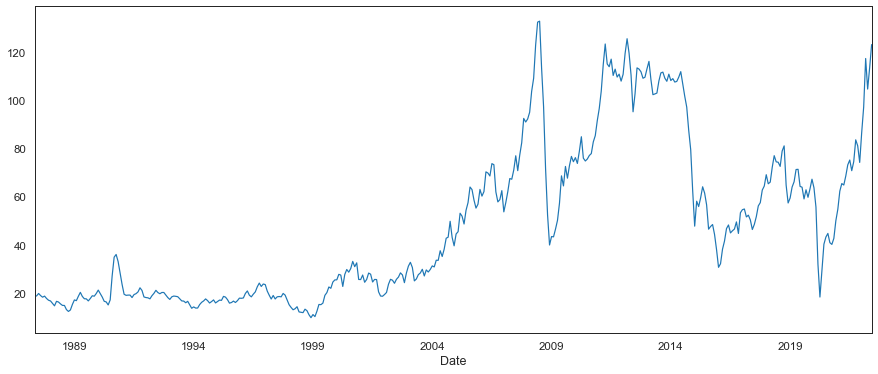

In [9]:
y.plot(figsize=(15, 6))
plt.show()

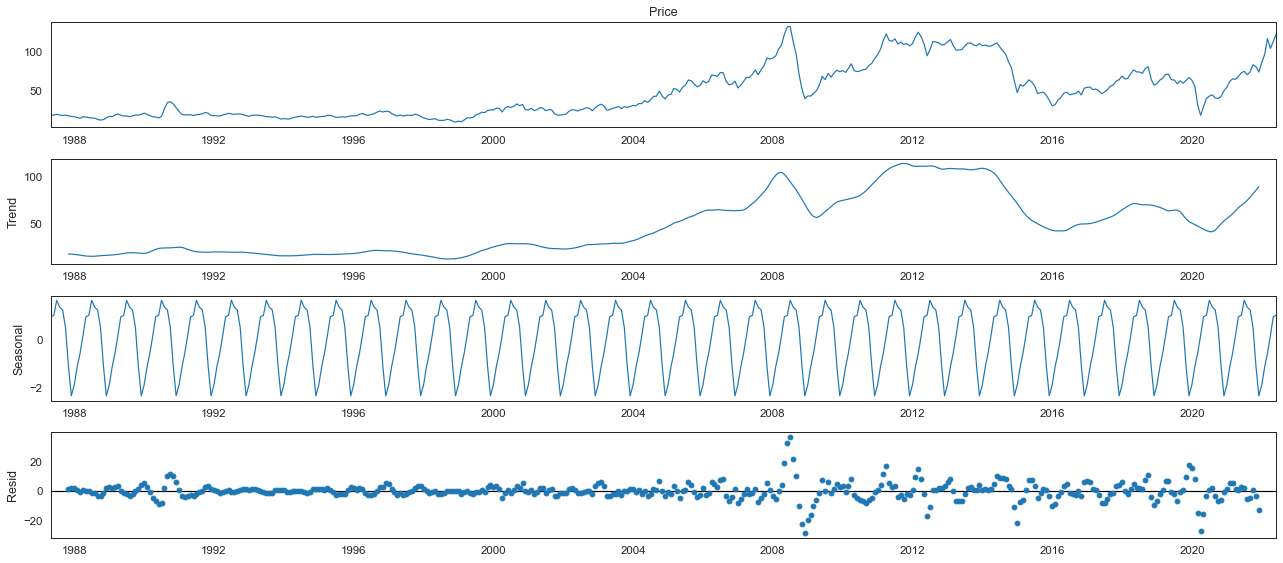

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [11]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

In [12]:
# split into train and test sets
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [13]:
train

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       ...,
       [0.74942529],
       [0.74875788],
       [0.73511309]])

In [14]:
train.shape

(6237, 1)

In [15]:
test

array([[0.73274008],
       [0.73207267],
       [0.74267705],
       ...,
       [0.7816092 ],
       [0.80281795],
       [0.8200964 ]])

In [16]:
test.shape

(2674, 1)

In [17]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [18]:
# reshape into X=t and Y=t+1
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [19]:
# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
410/410 [==============================] - 35s 75ms/step - loss: 0.0027 - val_loss: 0.0844 - lr: 0.0010
Epoch 2/20
410/410 [==============================] - 34s 83ms/step - loss: 0.0088 - val_loss: 0.1038 - lr: 0.0010
Epoch 3/20
410/410 [==============================] - 41s 100ms/step - loss: 0.0106 - val_loss: 0.0692 - lr: 0.0010
Epoch 4/20
410/410 [==============================] - 46s 113ms/step - loss: 0.0095 - val_loss: 0.0826 - lr: 0.0010
Epoch 5/20
410/410 [==============================] - 47s 114ms/step - loss: 0.0029 - val_loss: 0.0054 - lr: 0.0010
Epoch 6/20
410/410 [==============================] - 60s 146ms/step - loss: 0.0011 - val_loss: 0.0043 - lr: 0.0010
Epoch 7/20
410/410 [==============================] - 55s 134ms/step - loss: 9.5943e-04 - val_loss: 0.0068 - lr: 0.0010
Epoch 8/20
410/410 [==============================] - 54s 131ms/step - loss: 9.9244e-04 - val_loss: 0.0090 - lr: 0.0010
Epoch 9/20
410/410 [==============================] - 52s 126ms/st

In [20]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

81/81 [==============================] - 4s 44ms/step


In [21]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Train Mean Absolute Error: 3.85727272491753
Train Root Mean Squared Error: 4.382211885830381
Test Mean Absolute Error: 1.6702099729590387
Test Root Mean Squared Error: 2.311633140898794


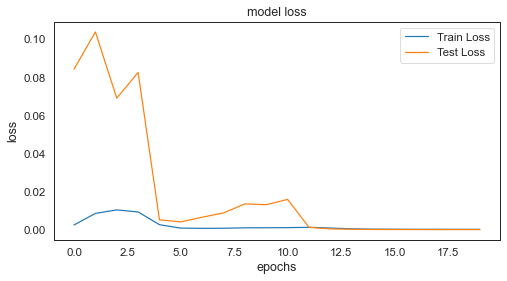

In [22]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

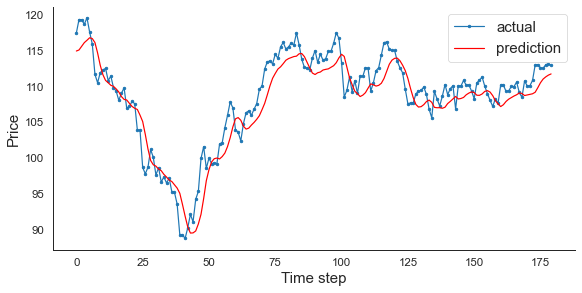

In [23]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();